<a href="https://colab.research.google.com/github/mariohzz/AI-camera/blob/master/vertex_label_annotator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ultralytics

In [ ]:
!pip install -q git+https://github.com/roboflow/supervision.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SOURCE_VIDEO_FILE = "/content/drive/MyDrive/llados.mov"

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8l-pose')

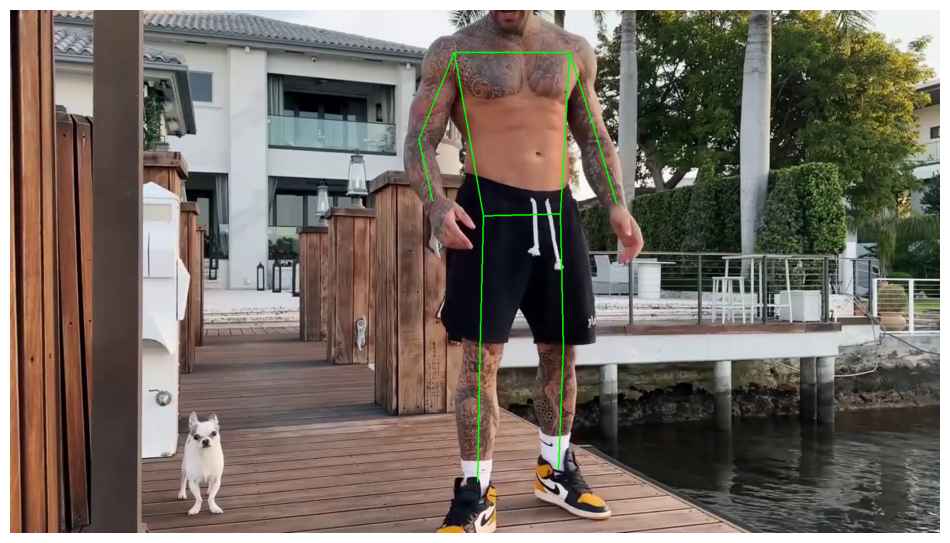

In [ ]:
import supervision as sv

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_FILE, start=50)
frame = next(frame_generator)

result = model(frame, verbose=False)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)

edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=2)
annotated_frame = edge_annotator.annotate(frame.copy(), keypoints)

sv.plot_image(annotated_frame)

In [ ]:
COCO_LABELS = [
    "nose",
    "left eye",
    "right eye",
    "left ear",
    "right ear",
    "left shoulder",
    "right shoulder",
    "left elbow",
    "right elbow",
    "left wrist",
    "right wrist",
    "left hip",
    "right hip",
    "left knee",
    "right knee",
    "left ankle",
    "right ankle",
]

COCO_COLORS = [
    "#FF6347",
    "#FF6347",
    "#FF6347",
    "#FF6347",
    "#FF6347",
    "#FF1493",
    "#00FF00",
    "#FF1493",
    "#00FF00",
    "#FF1493",
    "#00FF00",
    "#FFD700",
    "#00BFFF",
    "#FFD700",
    "#00BFFF",
    "#FFD700",
    "#00BFFF"
]

In [ ]:
import cv2
import math
import numpy as np

from typing import Union, Tuple, List, Optional

from supervision.draw.color import Color, ColorPalette
from supervision.geometry.core import Position
from supervision.annotators.utils import ColorLookup, Trace, resolve_color
from supervision.annotators.base import ImageType
from supervision.detection.core import Detections
from supervision.keypoint.core import KeyPoints


def get_intersection_center(xyxy_1: np.ndarray, xyxy_2: np.ndarray) -> Optional[Tuple[float, float]]:
    overlap_xmin = max(xyxy_1[0], xyxy_2[0])
    overlap_ymin = max(xyxy_1[1], xyxy_2[1])
    overlap_xmax = min(xyxy_1[2], xyxy_2[2])
    overlap_ymax = min(xyxy_1[3], xyxy_2[3])

    if overlap_xmin < overlap_xmax and overlap_ymin < overlap_ymax:
        x_center = (overlap_xmin + overlap_xmax) / 2
        y_center = (overlap_ymin + overlap_ymax) / 2
        return (x_center, y_center)
    else:
        return None


def get_box_center(xyxy: np.ndarray) -> Tuple[float, float]:
    x_center = (xyxy[0] + xyxy[2]) / 2
    y_center = (xyxy[1] + xyxy[3]) / 2
    return (x_center, y_center)


def vector_with_length(xy_1: Tuple[float, float], xy_2: Tuple[float, float], n: float) -> Tuple[float, float]:
    x1, y1 = xy_1
    x2, y2 = xy_2

    dx = x2 - x1
    dy = y2 - y1

    if dx == 0 and dy == 0:
        return 0, 0

    magnitude = math.sqrt(dx**2 + dy**2)

    unit_dx = dx / magnitude
    unit_dy = dy / magnitude

    v1 = unit_dx * n
    v2 = unit_dy * n

    return (v1, v2)


def pad(xyxy: np.ndarray, px: int, py: Optional[int] = None):
    if py is None:
        py = px

    result = xyxy.copy()
    result[:, [0, 1]] -= [px, py]
    result[:, [2, 3]] += [px, py]

    return result


def spread_out(xyxy: np.ndarray, step: float) -> np.ndarray:
    xyxy_padded = pad(xyxy, px=step)
    while True:
        iou = sv.box_iou_batch(xyxy_padded, xyxy_padded)
        np.fill_diagonal(iou, 0)

        if np.all(iou == 0):
            return pad(xyxy_padded, px=-step)

        i, j = np.unravel_index(np.argmax(iou), iou.shape)

        xyxy_i, xyxy_j = xyxy_padded[i], xyxy_padded[j]
        intersection_center = get_intersection_center(xyxy_i, xyxy_j)
        xyxy_i_center = get_box_center(xyxy_i)
        xyxy_j_center = get_box_center(xyxy_j)

        vector_i = vector_with_length(intersection_center, xyxy_i_center, step)
        vector_j = vector_with_length(intersection_center, xyxy_j_center, step)

        xyxy_padded[i, [0, 2]] += int(vector_i[0])
        xyxy_padded[i, [1, 3]] += int(vector_i[1])
        xyxy_padded[j, [0, 2]] += int(vector_j[0])
        xyxy_padded[j, [1, 3]] += int(vector_j[1])


class VertexLabelAnnotator:
    """
    A class for annotating labels on an image using provided detections.
    """

    def __init__(
        self,
        color: Color = Color.ROBOFLOW,
        text_color: Color = Color.WHITE,
        text_scale: float = 0.5,
        text_thickness: int = 1,
        text_padding: int = 10,
        border_radius: int = 0,
    ):
        self.border_radius: int = border_radius
        self.color: Union[Color, ColorPalette] = color
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_thickness: int = text_thickness
        self.text_padding: int = text_padding

    @staticmethod
    def get_text_bounding_box(
        text: str,
        font: int,
        text_scale: float,
        text_thickness: int,
        center_coordinates: Tuple[int, int],
        position: str = Position.CENTER
    ) -> Tuple[int, int, int, int]:
        text_w, text_h = cv2.getTextSize(
            text=text,
            fontFace=font,
            fontScale=text_scale,
            thickness=text_thickness,
        )[0]
        center_x, center_y = center_coordinates
        return (
            center_x - text_w // 2,
            center_y - text_h // 2,
            center_x + text_w // 2,
            center_y + text_h // 2,
        )

    def annotate(
        self,
        scene: ImageType,
        key_points: KeyPoints,
        labels: List[str] = None,
        custom_color_lookup: Optional[np.ndarray] = None,
    ) -> ImageType:
        font = cv2.FONT_HERSHEY_SIMPLEX

        N, K, _ = key_points.xy.shape

        if N == 0:
            return scene

        anchors = key_points.xy.reshape(K * N, 2).astype(int)
        colors = np.array(COCO_COLORS * N)
        labels = np.array(COCO_LABELS * N)

        mask = np.all(anchors != 0, axis=1)

        if np.all(mask == False):
            return scene

        anchors = anchors[mask]
        colors = colors[mask]
        labels = labels[mask]

        xyxy = np.array([
            self.get_text_bounding_box(
                text=label,
                font=font,
                text_scale=self.text_scale,
                text_thickness=self.text_thickness,
                center_coordinates=tuple(anchor)
            )
            for anchor, label
            in zip(anchors, labels)
        ])

        xyxy_padded = pad(xyxy=xyxy, px=self.text_padding)
        xyxy_padded = spread_out(xyxy_padded, step=2)
        xyxy = pad(xyxy=xyxy_padded, px=-self.text_padding)

        for text, color, box, box_padded in zip(labels, colors, xyxy, xyxy_padded):
            color = Color.from_hex(color)

            self.draw_rounded_rectangle(
                scene=scene,
                xyxy=tuple(box_padded),
                color=color.as_bgr(),
                border_radius=self.border_radius,
            )
            cv2.putText(
                img=scene,
                text=text,
                org=(box[0], box[1] + self.text_padding),
                fontFace=font,
                fontScale=self.text_scale,
                color=self.text_color.as_rgb(),
                thickness=self.text_thickness,
                lineType=cv2.LINE_AA,
            )

        return scene

    @staticmethod
    def draw_rounded_rectangle(
        scene: np.ndarray,
        xyxy: Tuple[int, int, int, int],
        color: Tuple[int, int, int],
        border_radius: int,
    ) -> np.ndarray:
        x1, y1, x2, y2 = xyxy
        width = x2 - x1
        height = y2 - y1

        border_radius = min(border_radius, min(width, height) // 2)

        rectangle_coordinates = [
            ((x1 + border_radius, y1), (x2 - border_radius, y2)),
            ((x1, y1 + border_radius), (x2, y2 - border_radius)),
        ]
        circle_centers = [
            (x1 + border_radius, y1 + border_radius),
            (x2 - border_radius, y1 + border_radius),
            (x1 + border_radius, y2 - border_radius),
            (x2 - border_radius, y2 - border_radius),
        ]

        for coordinates in rectangle_coordinates:
            cv2.rectangle(
                img=scene,
                pt1=coordinates[0],
                pt2=coordinates[1],
                color=color,
                thickness=-1,
            )
        for center in circle_centers:
            cv2.circle(
                img=scene,
                center=center,
                radius=border_radius,
                color=color,
                thickness=-1,
            )
        return scene

In [ ]:
# edge_annotator = sv.EdgeAnnotator(color=Color.WHITE, thickness=2)
# vertex_label_annotator = VertexLabelAnnotator(border_radius=5, text_color=Color.BLACK)

# annotated_frame = frame.copy()
# annotated_frame = edge_annotator.annotate(annotated_frame, keypoints)
# annotated_frame = vertex_label_annotator.annotate(annotated_frame, keypoints)
# sv.cv2_to_pillow(annotated_frame)

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_FILE)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_FILE, start=60, end=8 * 60)

edge_annotator = sv.EdgeAnnotator(color=Color.WHITE, thickness=2)
vertex_label_annotator = VertexLabelAnnotator(border_radius=5, text_color=Color.BLACK)

with sv.VideoSink("result.mp4", video_info=video_info) as sink:

    for frame in frame_generator:
        result = model(frame, verbose=False)[0]
        keypoints = sv.KeyPoints.from_ultralytics(result)

        annotated_frame = frame.copy()
        annotated_frame = edge_annotator.annotate(annotated_frame, keypoints)
        annotated_frame = vertex_label_annotator.annotate(annotated_frame, keypoints)

        sink.write_frame(annotated_frame)